CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [61]:
!pip install captum

Defaulting to user installation because normal site-packages is not writeable


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, r2_score


> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
# TODO: Enter your code here

df = pd.read_csv('hdb_price_prediction.csv')

numeric_df = df.drop(columns=['town', 'month', 'full_address', 'nearest_stn', 'storey_range', 'flat_model_type', ])

train_df = numeric_df[numeric_df['year'] <= 2019]
train_df = train_df.drop(columns=['year'])
val_df = numeric_df[numeric_df['year'] == 2020]
val_df = val_df.drop(columns=['year'])
test_df = numeric_df[numeric_df['year'] == 2021]
test_df = test_df.drop(columns=['year'])


> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# TODO: Enter your code here

# Prepare data
X_train = torch.from_numpy(train_df.drop(columns=['resale_price']).to_numpy()).float() # torch.Size([64057, 6])
y_train = torch.tensor(train_df['resale_price'].values).view(-1, 1).float() # torch.Size([64057, 1])

X_test = torch.from_numpy(test_df.drop(columns=['resale_price']).to_numpy()).float() # torch.Size([29057, 6])
y_test = torch.tensor(test_df['resale_price'].values).view(-1, 1).float() # torch.Size([29057, 1])


datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

# Set default hyperparams
batch_size = 50
num_epochs = 200
learning_rate = 0.001
size_hidden1 = 5
size_hidden2 = 5
size_hidden3 = 5
size_output = 1

# Build model
class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Only 6 input features after dropping categorical features and the target feature 'resale_price'
        self.lin1 = nn.Linear(6, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_output)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

# Train model
criterion = nn.MSELoss(reduction='sum')
def train(model_inp, train_iter, num_epochs):
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0 # for each epoch
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0
    return model_inp



In [5]:
model = myModel()
model.train()
model = train(model, train_iter, num_epochs)


Epoch [1]/[200] running accumulative loss across all batches: 3525035386140672.000
Epoch [21]/[200] running accumulative loss across all batches: 343053684588032.000
Epoch [41]/[200] running accumulative loss across all batches: 340213444570368.000
Epoch [61]/[200] running accumulative loss across all batches: 338940312517632.000
Epoch [81]/[200] running accumulative loss across all batches: 337912041238528.000
Epoch [101]/[200] running accumulative loss across all batches: 337130842230784.000
Epoch [121]/[200] running accumulative loss across all batches: 286533013328384.000
Epoch [141]/[200] running accumulative loss across all batches: 275181386555136.000
Epoch [161]/[200] running accumulative loss across all batches: 265957875625984.000
Epoch [181]/[200] running accumulative loss across all batches: 261405887604224.000


In [6]:
# Evaluate model
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model rsme: ', err)

model rsme:  91983.29


In [47]:
# Attributions
def saliency(model, test):
	sal = Saliency(model)
	sal_attr_test = sal.attribute(test)
	return sal_attr_test

def	input_x_gradient(model, test):
	ixg = InputXGradient(model)
	ixg_attr_test = ixg.attribute(test)
	return ixg_attr_test

def integrated_gradients(model, test):
	ig = IntegratedGradients(model)
	ig_attr_test = ig.attribute(test, n_steps=50)
	return ig_attr_test

def gradient_shap(model, test, train):
	gs = GradientShap(model)
	# use the entire training dataset as the distribution of baselines
	gs_attr_test = gs.attribute(test, train)
	return gs_attr_test

def feature_ablation(model, test):
	fa = FeatureAblation(model)
	fa_attr_test = fa.attribute(test)
	return fa_attr_test

def attr_norm_sum(attr_test):
	attr_test_sum = attr_test.detach().numpy().sum(0)
	attr_test_norm_sum = attr_test_sum / np.linalg.norm(attr_test_sum, ord=1)
	return attr_test_norm_sum

def get_y_axis_lin_weight(model):
	lin_weight = model.lin1.weight[0].detach().numpy()
	y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)
	return y_axis_lin_weight

# Plottings
def plot(x_test, attr_test_norm_sum_dict, y_axis_lin_weight, title='Comparing input feature importances across multiple algorithms and learned weights', legends=['Saliency', 'Input X Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation', 'Weights']):
	width = 0.14
	plt.figure(figsize=(20, 10))
	ax = plt.subplot()
	ax.set_title(title)
	ax.set_ylabel('Attributions')
	FONT_SIZE = 16
	plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
	plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
	plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
	plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

	x_axis_data = np.arange(x_test.shape[1])
	feature_names = list(train_df.drop(columns=['resale_price']).columns)
	x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

	i = 1
	colours = ['#A90000', '#34b8e0', '#eb5e7c', '#4260f5', '#49ba81', 'grey']
	attr_test_norm_sum = list(attr_test_norm_sum_dict.values())
	while i <= len(attr_test_norm_sum):
		ax.bar(x_axis_data + i * width, attr_test_norm_sum[i-1], width, align='center', alpha=0.75, color=colours[i-1])
		i += 1
	ax.bar(x_axis_data + i * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')

	ax.autoscale_view()
	plt.tight_layout()
	ax.set_xticks(x_axis_data + 0.5)
	ax.set_xticklabels(x_axis_data_labels)
	ax.grid(axis='y')
	plt.legend(legends, loc=3)
	plt.show()

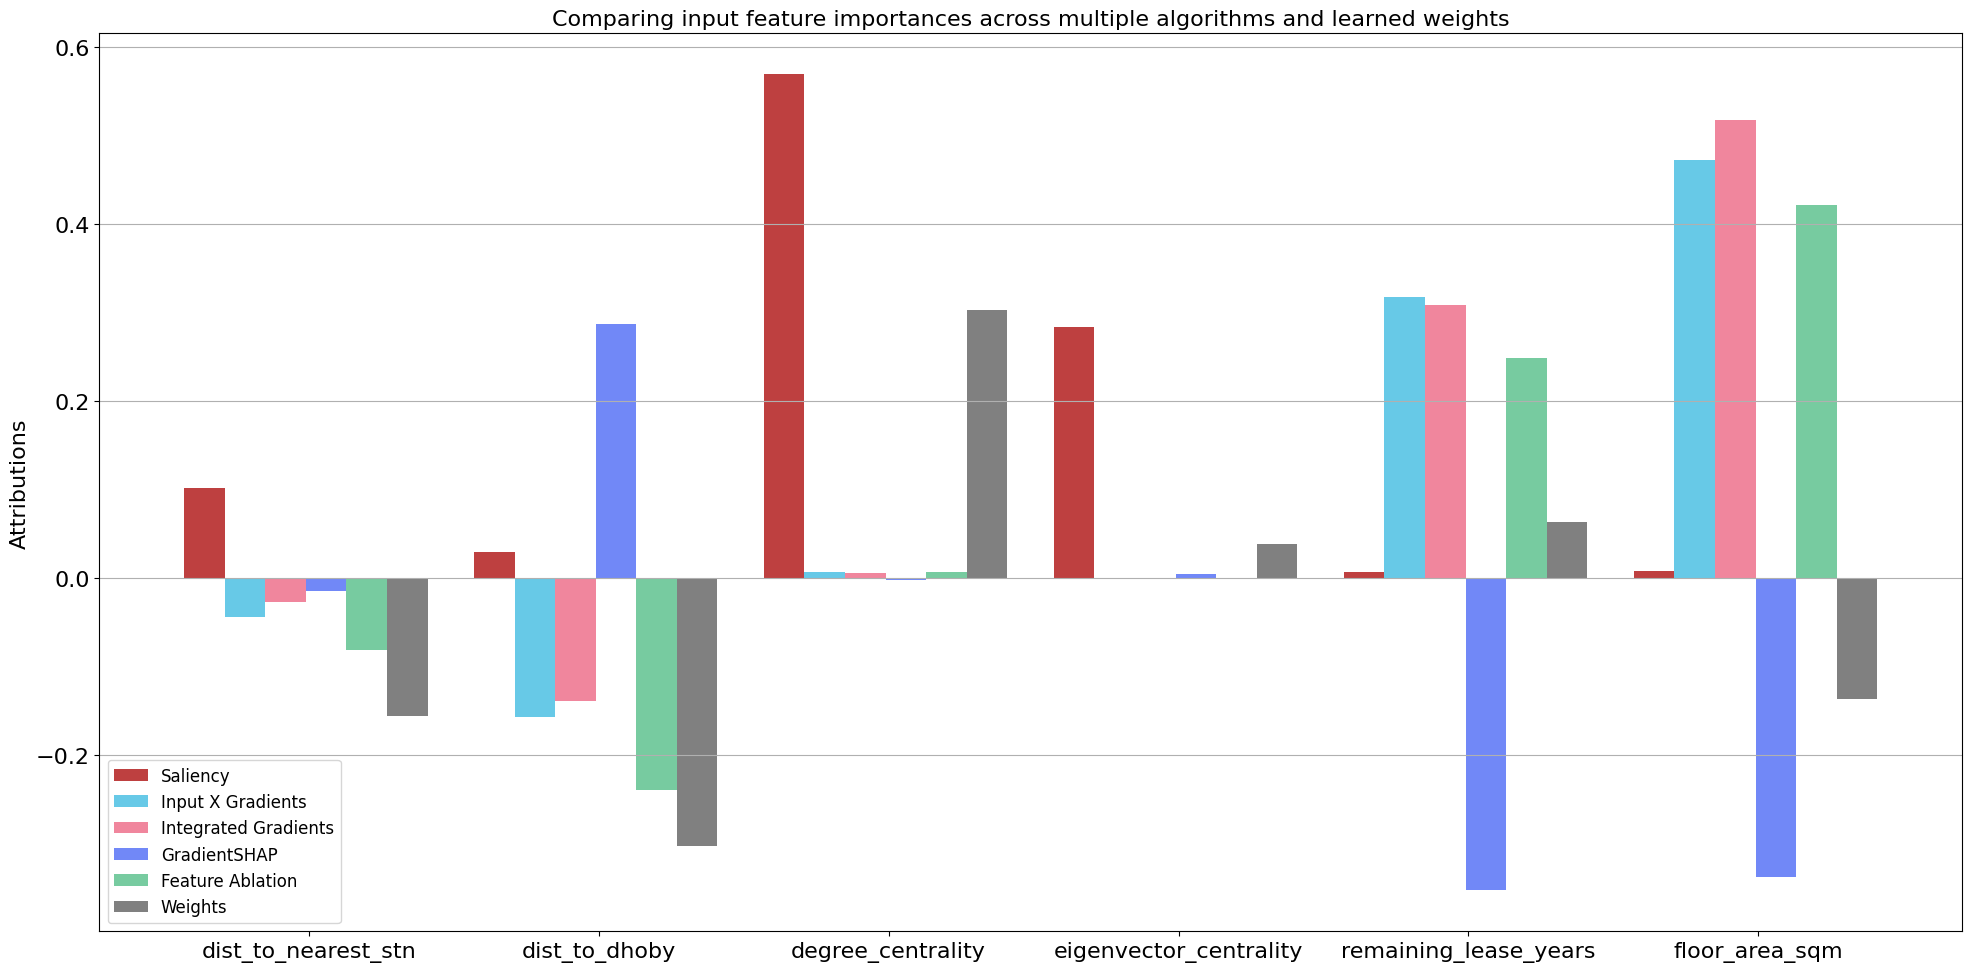

In [48]:
# For the attribution calculations, we will limit the test input size to 1000
X_test_1000 = X_test[:1000]

sal_attr_test = saliency(model, X_test_1000)
ixg_attr_test = input_x_gradient(model, X_test_1000)
ig_attr_test = integrated_gradients(model, X_test_1000)
# For GradientSHAP, use the training set as the baseline
gs_attr_test = gradient_shap(model, X_test_1000, X_train)
fa_attr_test = feature_ablation(model, X_test_1000)

# Create  a dictionary {key=algorithm_name : value=attribution_score}
attr_test_norm_sum_dict = {}
str_list = ['sal', 'ixg', 'ig', 'gs', 'fa']
attr_test_list = [sal_attr_test, ixg_attr_test, ig_attr_test, gs_attr_test, fa_attr_test]
for i in range(len(str_list)):
	attr_test_norm_sum_dict[str_list[i]] = list(attr_norm_sum(attr_test_list[i]))

y_axis_lin_weight = get_y_axis_lin_weight(model)

plot(X_test_1000, attr_test_norm_sum_dict, y_axis_lin_weight)


> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [9]:
y_train_df = train_df['resale_price'] # (64057,)
torch.tensor(y_train_df.values).shape

torch.Size([64057])

In [10]:
# TODO: Enter your code here

# Scale data
X_train_df = train_df.drop(columns=['resale_price']) # (64057, 6) 
X_test_df = test_df.drop(columns=['resale_price']) # (29057, 6)
y_train_df = train_df['resale_price'] # (64057,)
y_test_df = test_df['resale_price'] # (29057,)

x_standard_scaler = preprocessing.StandardScaler()
# Fit standard scaler on training data
x_standard_scaler.fit(X_train_df)

# Transform training and test data
x_train_scaled = x_standard_scaler.transform(X_train_df)
X_train_scaled_tensor = torch.tensor(x_train_scaled, dtype=torch.float32) #torch.Size([64057, 6]) 
x_test_scaled = x_standard_scaler.transform(X_test_df)
X_test_scaled_tensor = torch.tensor(x_test_scaled, dtype=torch.float32) #torch.Size([29057, 6]) 

y_train_tensor = torch.tensor(y_train_df.values, dtype=torch.float32) #torch.Size([64057])
y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32) #torch.Size([29057])


# Load data
datasets_scaled = torch.utils.data.TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_iter_scaled = torch.utils.data.DataLoader(datasets_scaled, batch_size=10, shuffle=True)



In [11]:
# Create and train model
model_scaled = myModel()
model_scaled.train()
model_scaled = train(model_scaled, train_iter_scaled, num_epochs)

# Evaluate model
model_scaled.eval()
outputs = model_scaled(X_test_scaled_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('model err: ', err)

/Users/limxinyi/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/limxinyi/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1]/[200] running accumulative loss across all batches: 100750795180998656.000
Epoch [21]/[200] running accumulative loss across all batches: 15069547407638528.000
Epoch [41]/[200] running accumulative loss across all batches: 15066247662485504.000
Epoch [61]/[200] running accumulative loss across all batches: 15064140968771584.000
Epoch [81]/[200] running accumulative loss across all batches: 15061777337516032.000
Epoch [101]/[200] running accumulative loss across all batches: 15060604345794560.000
Epoch [121]/[200] running accumulative loss across all batches: 15067010827354112.000
Epoch [141]/[200] running accumulative loss across all batches: 15062824892776448.000
Epoch [161]/[200] running accumulative loss across all batches: 15079118253178880.000
Epoch [181]/[200] running accumulative loss across all batches: 15059732563410944.000
model err:  166550.84


/Users/limxinyi/Library/Python/3.9/lib/python/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


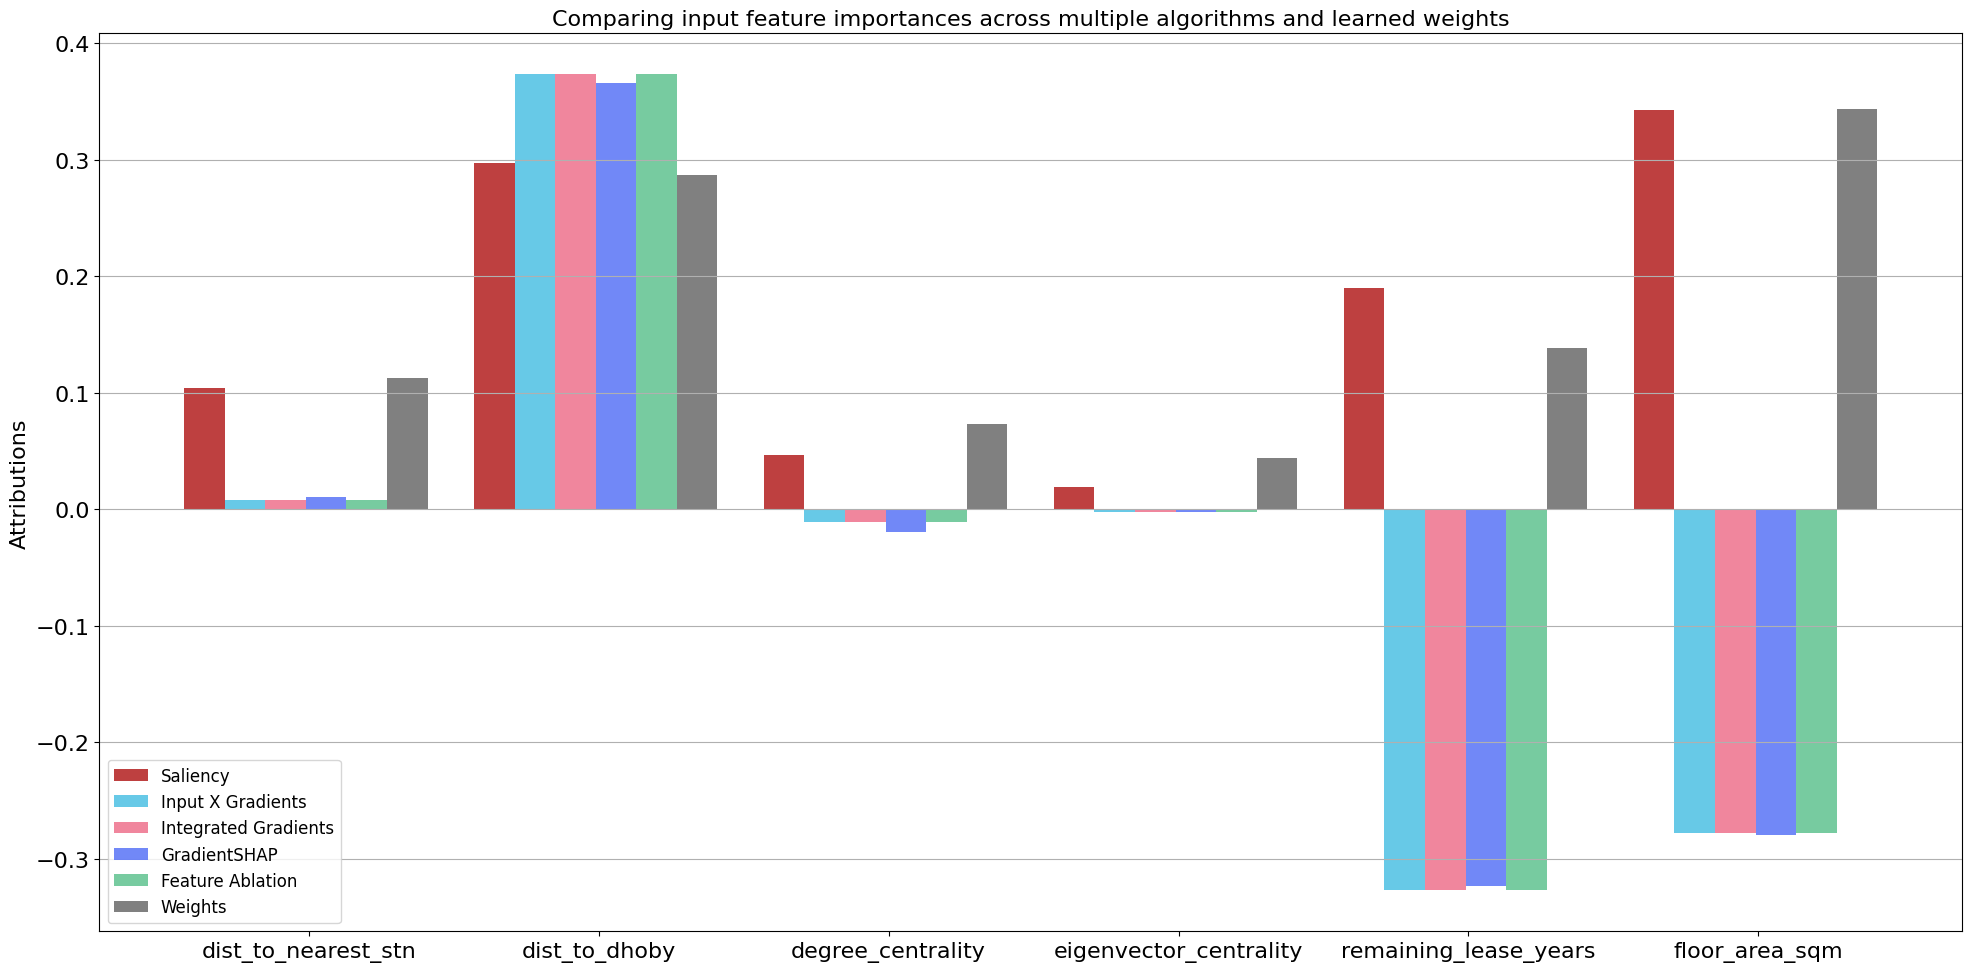

In [49]:
# For the attribution calculations, we will limit the test input size to 1000

X_test_1000_scaled = X_test_scaled_tensor[:1000]

sal_scaled = saliency(model_scaled, X_test_1000_scaled)
ixg_scaled = input_x_gradient(model_scaled, X_test_1000_scaled)
ig_scaled = integrated_gradients(model_scaled, X_test_1000_scaled)
# For GradientSHAP, use the scaled training set as the baseline
gradshap_scaled = gradient_shap(model_scaled, X_test_1000_scaled, X_train_scaled_tensor)
fa_scaled = feature_ablation(model_scaled, X_test_1000_scaled)


# Create  a dictionary {key=algorithm_name : value=attribution_score}
attr_test_norm_sum_dict_scaled = {}
str_list = ['sal', 'ixg', 'ig', 'gs', 'fa']
attr_test_list_scaled = [sal_scaled, ixg_scaled, ig_scaled, gradshap_scaled, fa_scaled]
for i in range(len(str_list)):
	attr_test_norm_sum_dict_scaled[str_list[i]] = list(attr_norm_sum(attr_test_list_scaled[i]))


y_axis_lin_weight_scaled = get_y_axis_lin_weight(model_scaled)

plot(X_test_1000_scaled, attr_test_norm_sum_dict_scaled, y_axis_lin_weight_scaled)

In [54]:
train_df.columns

Index(['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
       'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm',
       'resale_price'],
      dtype='object')

In [59]:
gs_ig_table = pd.DataFrame({'Features': ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm'], 'GradientSHAP Scaled': attr_test_norm_sum_dict_scaled['gs'],
										'Integrated Gradients Scaled': attr_test_norm_sum_dict_scaled['ig'],
                   'GradientSHAP Non-scaled': attr_test_norm_sum_dict['gs'], 
									 'Integrated Gradients Non-scaled': attr_test_norm_sum_dict['ig'],
                  })

gs_ig_table

,Features,GradientSHAP Scaled,Integrated Gradients Scaled,GradientSHAP Non-scaled,Integrated Gradients Non-scaled
0,dist_to_nearest_stn,0.010338,0.008277,-0.014955,-0.027145
1,dist_to_dhoby,0.365814,0.373536,0.286832,-0.139320
2,degree_centrality,-0.019120,-0.011088,-0.001976,0.005956
3,eigenvector_centrality,-0.002191,-0.002172,0.004995,-0.000886
4,remaining_lease_years,-0.323027,-0.327025,-0.352962,0.309174
5,floor_area_sqm,-0.279511,-0.277902,-0.338280,0.517519


In [60]:
# Observations
"""
In the model trained and tested on scaled data, GradientSHAP and Integrated Gradients produce very similar attribution values. But in the non-scaled case, they produce vastly different attributions including attributions of different signs (eg. dist_to_dhoby GradientSHAP non-scaled gave positive but Integrated Gradients non-scaled gave negative)
Additionally, attributions scores produced by GradientSHAP in both the scaled and non-scaled do not differ much, as opposed to Integrated Gradients. 
This is because GradientSHAP computations are based on the baseline, which is X_train and X_train_scaled in our two models respectively. But for Integrated Gradients, the baseline is assumed to be an all-zeroes vector as mentioned in the documentation, hence the attribution score can vary a lot depending on whether the data input to the model was scaled or not.
"""

'\nIn the model trained and tested on scaled data, GradientSHAP and Integrated Gradients produce very similar attribution values. But in the non-scaled case, they produce vastly different attributions including attributions of different signs (eg. dist_to_dhoby GradientSHAP non-scaled gave positive but Integrated Gradients non-scaled gave negative)\nAdditionally, attributions scores produced by GradientSHAP in both the scaled and non-scaled do not differ much, as opposed to Integrated Gradients. \nThis is because GradientSHAP computations are based on the baseline, which is X_train and X_train_scaled in our two models respectively. But for Integrated Gradients, the baseline is assumed to be 0 as mentioned in the documentation, hence the attribution score can vary a lot depending on whether the data input to the model was scaled or not.\n'

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


\# TODO: \<Enter your answer here\>

In both the scaled and non-scaled cases, Saliency did not really produce scores similar to IG.
<br>
This is because IG score is obtained after a multiplication with the input (given that x' is 0 since baseline assumed to be all-zeroes vector), that is absent in Saliency which purely considers the gradient of output with respect to input. Hence, depening on the input value, the IG score can be very different from the Saliency score.
Additionally, IG also takes into account alpha while Saliency does not

> Why did Input x Gradients give the same attribution scores as IG?


\# TODO: \<Enter your answer here\>

In both the scaled and non-scaled cases, Input x Gradients give attribution scores that are almost completely identical as IG (only minor differences in the non-scaled case.) <br>
This is because in our context here, both Input x Gradients and IG use the zero-vector as their baselines. <br>
Hence, the computation for IG simplifies to the product of the input (instead of difference between input and basline if zero-vector was not assumed) and the integral of alpha multipied by the gradient of the output with respect to the input over alpha. Meanwhile, Input x Gradients also considers the product of the input and the gradient of output with respect to input.
Thus, Input x Gradients and IG give almost identical attribution scores